<a href="https://colab.research.google.com/github/miguelcasadinho/colab/blob/main/rnn_5m_288ts_12output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1 - Data cleaning

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Import the dataset

In [2]:
dataset = pd.read_csv('za1_train.csv')
dataset_test = pd.read_csv('za1_test.csv')
print(dataset.shape)
print(dataset_test.shape)

(109391, 2)
(508, 2)


Arredondar para o múltiplo de 5 minutos mais próximo

In [3]:
def round_to_nearest_5_minutes(timestamp):
    minutes = timestamp.minute
    nearest_5 = 5 * round(minutes / 5)

    if nearest_5 == 60:
        # Verifique se a hora é 23 e, se for, ajuste para o próximo dia
        if timestamp.hour == 23:
            return timestamp.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(days=1)
        else:
            return timestamp.replace(hour=timestamp.hour + 1, minute=0, second=0, microsecond=0)
    else:
        return timestamp.replace(minute=nearest_5, second=0, microsecond=0)

In [4]:
# Convert 'Time' column to datetime objects
dataset['Time'] = pd.to_datetime(dataset['Time'])
dataset_test['Time'] = pd.to_datetime(dataset_test['Time'])
dataset['Time'] = dataset['Time'].apply(round_to_nearest_5_minutes)
dataset_test['Time'] = dataset_test['Time'].apply(round_to_nearest_5_minutes)
#print(dataset_test)
print(dataset.shape)
print(dataset_test.shape)

(109391, 2)
(508, 2)


Handling rows with NaN values

In [5]:
# Identify rows with NaN values
dataset_rows_with_nan = dataset[dataset.isnull().any(axis=1)]
#print("Rows with NaN in dataset:", dataset_rows_with_nan)
dataset_test_rows_with_nan = dataset[dataset.isnull().any(axis=1)]
#print("Rows with NaN in dataset:", dataset_test_rows_with_nan)

# Deleting rows with NaN values
dataset.dropna(inplace=True)
dataset_test.dropna(inplace=True)

print(dataset.shape)
print(dataset_test.shape)

(109391, 2)
(508, 2)


Handling duplicates timestamps

In [6]:
dataset_duplicate_rows = dataset[dataset.duplicated(subset=['Time'])]
#print("Number of duplicate rows in dataset:", len(dataset_duplicate_rows))
dataset_test_duplicate_rows = dataset_test[dataset_test.duplicated(subset=['Time'])]
#print("Number of duplicate rows in dataset_test:", len(dataset_test_duplicate_rows))
# Remove the duplicate rows based on Time:
dataset.drop_duplicates(subset=['Time'], inplace=True)
dataset_test.drop_duplicates(subset=['Time'], inplace=True)

print(dataset.shape)
print(dataset_test.shape)


(84920, 2)
(296, 2)


Outlier detection and treatment using Z-score

In [7]:
from scipy.stats import zscore
# Calculate Z-scores for the dataset
z_scores_dataset = zscore(dataset['Distribuído'])
z_scores_dataset_test = zscore(dataset_test['Distribuído'])

# Set the Z-score threshold (e.g., 5 standard deviations)
threshold = 5

# Identify outliers based on Z-score threshold
dataset_outliers =  np.where(np.abs(z_scores_dataset) > threshold)
#print("Outliers identified in dataset:", dataset.iloc[dataset_outliers[0]])
dataset_test_outliers =  np.where(np.abs(z_scores_dataset_test) > threshold)
#print("Outliers identified in dataset_test:", dataset_test.iloc[dataset_test_outliers[0]])

# Remove outliers from the dataset
dataset = dataset[(np.abs(z_scores_dataset) <= threshold)]
dataset_test = dataset_test[(np.abs(z_scores_dataset_test) <= threshold)]

print(dataset.shape)
print(dataset_test.shape)

(84920, 2)
(296, 2)


Find gaps in the timedata

In [8]:
# Create a complete time index from min to max with 5-minute frequency
dataset_complete_time_index = pd.date_range(start=dataset['Time'].min(), end=dataset['Time'].max(), freq='5min')
dataset_test_complete_time_index = pd.date_range(start=dataset_test['Time'].min(), end=dataset_test['Time'].max(), freq='5min')

# Reindex the dataset with the complete time index
dataset = dataset.set_index('Time').reindex(dataset_complete_time_index)
dataset_test = dataset_test.set_index('Time').reindex(dataset_test_complete_time_index)

# Reset index to bring 'Time' back as a column
dataset.reset_index(inplace=True)
dataset_test.reset_index(inplace=True)
dataset.rename(columns={'index': 'Time'}, inplace=True)
dataset_test.rename(columns={'index': 'Time'}, inplace=True)

# Fill the NaN values in the 'Distribuído' column using forward fill and linear interpolation
dataset['Distribuído'] = dataset['Distribuído'].ffill()  # Forward fill
dataset['Distribuído'] = dataset['Distribuído'].interpolate(method='linear')  # Linear interpolation
dataset_test['Distribuído'] = dataset_test['Distribuído'].ffill()  # Forward fill
dataset_test['Distribuído'] = dataset_test['Distribuído'].interpolate(method='linear')  # Linear interpolation

print(dataset.shape)
print(dataset_test.shape)


(88704, 2)
(300, 2)


Set time as index and extract 'flow'

In [9]:
dataset.set_index('Time', inplace=True)
dataset_test.set_index('Time', inplace=True)
values = dataset['Distribuído'].values
values = dataset_test['Distribuído'].values
print(dataset.shape)
print(dataset_test.shape)

(88704, 1)
(300, 1)


Feature engineering (extract useful time features)

In [10]:
dataset['Month'] = dataset.index.month
dataset_test['Month'] = dataset_test.index.month
dataset['day_of_month'] = dataset.index.day
dataset_test['day_of_month'] = dataset_test.index.day
dataset['day_of_week'] = dataset.index.dayofweek
dataset_test['day_of_week'] = dataset_test.index.dayofweek
dataset['Hour'] = dataset.index.hour
dataset_test['Hour'] = dataset_test.index.hour
dataset['Minute'] = dataset.index.minute
dataset_test['Minute'] = dataset_test.index.minute

print(dataset.shape)
print(dataset_test.shape)

(88704, 6)
(300, 6)


Save to CSV file

In [11]:
dataset.to_csv('dataset.csv', index=True)
dataset_test.to_csv('dataset_test.csv', index=True)

Part 2 - Data preprocessing

In [12]:
# Leave only the flow column
training_set = dataset.iloc[:, 0:7].values
test_set = dataset_test.iloc[:, 0:7].values
print(training_set.shape)
print(test_set.shape)

(88704, 6)
(300, 6)


Feature scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)
print(training_set_scaled.shape)
print(test_set_scaled.shape)

(88704, 6)
(300, 6)


Creating a data structure with 24 hours timesteps and 1 hour 12 outputs

In [14]:
X_train = []
y_train = []
# 24 hours are 288 (12x24) sequences
sequence_length = 288
forecast_horizon = 12

for i in range(sequence_length, len(training_set_scaled) - forecast_horizon + 1):
    X_train.append(training_set_scaled[i-sequence_length:i])
    y_train.append(training_set_scaled[i:i + forecast_horizon, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(88405, 288, 6)
(88405, 12)


Reshaping input data for LSTM: [samples, time steps, features]

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
print(X_train.shape)

(88405, 288, 6)


Part 3 - Building the RNN

In [16]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Create 50 neurons and drop 20%
# Add an Input layer to specify the shape of the input
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
# Adding the LSTM layers and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = forecast_horizon))

Compiling the RNN

In [17]:
from keras.metrics import MeanAbsoluteError # Monitoring Model Performance
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[MeanAbsoluteError()])

# Callbacks for early stopping and model checkpointing
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_flow_prediction_model.keras', save_best_only=True)

# Validation Set
from sklearn.model_selection import train_test_split
# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Fitting the RNN to the Training set

In [ ]:
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping, model_checkpoint])

# Save the model
regressor.save('flow_prediction_model.keras')

Epoch 1/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 96s 41ms/step - loss: 0.0116 - mean_absolute_error: 0.0800 - val_loss: 0.0048 - val_mean_absolute_error: 0.0529
Epoch 2/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 140s 41ms/step - loss: 0.0051 - mean_absolute_error: 0.0550 - val_loss: 0.0042 - val_mean_absolute_error: 0.0494
Epoch 3/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 89s 40ms/step - loss: 0.0045 - mean_absolute_error: 0.0516 - val_loss: 0.0040 - val_mean_absolute_error: 0.0480
Epoch 4/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 0.0041 - mean_absolute_error: 0.0493 - val_loss: 0.0037 - val_mean_absolute_error: 0.0463
Epoch 5/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 142s 40ms/step - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0036 - val_mean_absolute_error: 0.0460
Epoch 6/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 143s 40ms/step - loss: 0.0038 - mean_absolute_error: 0.0477 - val_loss: 0.0036 - val_mean_absolute_error: 0.0455
Epoch 7/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 141s 40ms/step - loss: 0.0037 

Part 4 - Making the predictions and visualising the results

In [ ]:

# Prepare test inputs
X_test = []
y_test = []
for i in range(sequence_length, len(test_set_scaled) - forecast_horizon + 1):
    X_test.append(test_set_scaled[i - sequence_length:i])



X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

predicted_flow = regressor.predict(X_test)
predicted_flow = sc.inverse_transform(predicted_flow)

#print(predicted_flow)
last_hour = predicted_flow[-1:].flatten()
print(last_hour)
print(predicted_flow.shape)


(73, 72, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[17.459745 17.471441 17.531248 17.492582 17.301046 17.473026 17.3721
 17.252354 17.31221  17.347906 17.274775 17.206593]
(73, 12)


Visualising the results

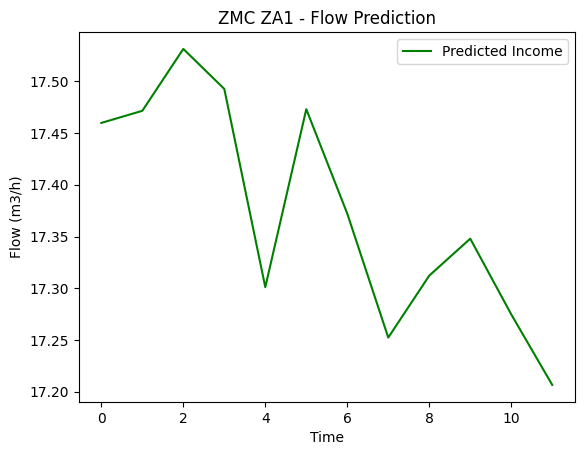

"\nplt.plot(dataset_test.index[sequence_length + forecast_horizon - 1:], dataset_test['Distribuído'].values[sequence_length + forecast_horizon - 1:], color='blue', label='Actual Income')\nplt.plot(dataset_test.index[sequence_length + forecast_horizon - 1:], predicted_flow[:, 0], color='green', label='Predicted Income')\nplt.title('ZMC ZA1 - Flow Prediction')\nplt.xlabel('Time')\nplt.ylabel('Flow (m3/h)')\nplt.legend()\n\n# Save the plot to a file instead of displaying it\nplt.savefig('flow_prediction.png')\n\nplt.show()\n"

In [ ]:
plt.plot (last_hour, color='green', label='Predicted Income')
plt.title('ZMC ZA1 - Flow Prediction')
plt.xlabel('Time')
plt.ylabel('Flow (m3/h)')
plt.legend()
plt.show()

'''
plt.plot(dataset_test.index[sequence_length + forecast_horizon - 1:], dataset_test['Distribuído'].values[sequence_length + forecast_horizon - 1:], color='blue', label='Actual Income')
plt.plot(dataset_test.index[sequence_length + forecast_horizon - 1:], predicted_flow[:, 0], color='green', label='Predicted Income')
plt.title('ZMC ZA1 - Flow Prediction')
plt.xlabel('Time')
plt.ylabel('Flow (m3/h)')
plt.legend()

# Save the plot to a file instead of displaying it
plt.savefig('flow_prediction.png')

plt.show()
'''